# SAC for simple car game

_____________________
Implementation below
_____________________

This is using an older implementation of SAC, with two duelling Q functions, two value functions and a policy function. According to the SAC paper, each of these functions is a dense NN with 2 hidden layers and 256 hidden units.

The loss functions are [1]:
 * State value function $V$ with the associated parameters $\psi$ (weights, bias):  
 $J_{V}(\psi) = \mathbf{E}_{s_{t}\sim \mathcal{D}} \left[ \dfrac{1}{2} (V_{\psi}(s_{t}) - \mathbf{E}_{a_{t}\sim \pi_{\phi}} \left[ Q_{\theta} (s_{t},a_{t})- \mathrm{log} \pi_{\phi}(a_{t}|s_{t}) \right])^2\right]$,  
The part $\mathbf{E}_{a_{t}\sim \pi_{\phi}} \left[ Q_{\theta} (s_{t},a_{t})- \mathrm{log} \pi_{\phi}(a_{t}|s_{t}) \right]$ can be found in the code as:  
 ``
predicted_new_q_value = torch.min(q_network1(state, new_action),q_network2(state, new_action))
target_value_func = predicted_new_q_value - log_prob
 ``
 
 
 
* Q function $Q$ with the associated parameters $\theta$:  
$J_{Q}(\theta) =  \mathbf{E}_{(s_{t},a_{t})\sim D} \left[ \dfrac{1}{2} (Q_{\theta}(s_{t},a_{t}) - \hat{Q}(s_{t},a_{t}))^2 \right]$,  
with $\hat{Q}(s_{t},a_{t}) = r(s_{t},a_{t}) + \gamma \mathbf{E}_{(s_{t}+1)\sim p} \left[ V_{\psi}(s_{t+1}) \right]$  
$\hat{Q}(s_{t},a_{t})$ can be found in the code as:  
 ``
target_q_value = reward + (1 - done) * gamma * target_value_network(next_state)
 ``


* Policy function $\pi$ with the associated parameters $\phi$:  
$J_{\pi}(\phi) = \mathbf{E}_{s_{t}\sim \mathcal{D}, \epsilon_{t}\mathcal{N}}  \left[ \mathrm{log} \pi_{\phi} (f_{\phi}(\epsilon_{t};s_{t})|s_{t}) - Q_{\theta}(s_{t},f_{\phi}(\epsilon_{t};s_{t})) \right]$,  
is inside the code:  
``
(log_prob - predicted_new_q_value).mean()
``  
Especially interesting is the calculation of $\mathrm{log} \pi (a|s)$. For this, the reparameterization trick is used. If you want more information about this loss function, check out https://spinningup.openai.com/en/latest/algorithms/sac.html#id1


Symbols:  
$V$: State value function  
$\psi$: Parameters of state value function  
$Q$: Q function  
$\theta$: Parameters of Q function  
$\pi$: Policy function  
$\phi$: Parameters of policy function  
$s$: state of the game  
$a$: action  
$\mathbf{E}$: Expectation value  
$t$: time state

Here are some usefull impelementations I found:  
https://github.com/haarnoja/sac (tensorflow)  
https://github.com/facebookresearch/ReAgent/blob/50801113962c8cb145975d67256bb66ab4c229a4/ml/rl/training/sac_trainer.py (pytorch)  
https://github.com/vaishak2future/sac/blob/master/sac.ipynb (pytorch)  
https://github.com/higgsfield/RL-Adventure-2 (pytorch)  

_____________________
Training parameters are taken from the paper appendix or original implementation
_____________________

[1] https://arxiv.org/abs/1801.01290

### Importing eveything 

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import PygamePlayCar
from IPython.display import clear_output

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print(device)
env = PygamePlayCar.CarGame()

1 Physical GPUs, 1 Logical GPUs
pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
cuda


### Definition of used parameters

In [2]:
learning_rate = 3e-4
discount = 0.99
replay_buffer_size = 1e6
hidden_units = 256
batchsize = 256
target_smoothing_coefficient = 0.005
max_frames = (80000 * 20)
max_steps = 8000
frame_idx = 0
rewards = []
best_reward = 0

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
output_dir = 'SavedWeights/policy_network.pt'

### Function for plotting progress and definition of the replay buffer

In [3]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[int(self.position)] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)


### Definition of the functions and the training routine

In [4]:
class ValueFunction(nn.Module):
    def __init__(self, input_shape, hidden_units):
        super(ValueFunction, self).__init__()

        self.lay1 = nn.Linear(input_shape, hidden_units)
        self.lay2 = nn.Linear(hidden_units, hidden_units)
        self.lay3 = nn.Linear(hidden_units, 1)

    def forward(self, state):
        x = F.relu(self.lay1(state))
        x = F.relu(self.lay2(x))
        x = self.lay3(x)
        return x

class QFunction(nn.Module):
    def __init__(self, input_shape, hidden_units):
        super(QFunction, self).__init__()

        self.lay1 = nn.Linear(input_shape, hidden_units)
        self.lay2 = nn.Linear(hidden_units, hidden_units)
        self.lay3 = nn.Linear(hidden_units, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.lay1(x))
        x = F.relu(self.lay2(x))
        x = self.lay3(x)
        return x


class PolicyFunction(nn.Module):
    def __init__(self, input_shape, action_dimension, hidden_units, log_std_min_max=20):
        super(PolicyFunction, self).__init__()

        self.log_std_min_max = log_std_min_max
        self.lay1 = nn.Linear(input_shape, hidden_units)
        self.lay2 = nn.Linear(hidden_units, hidden_units)
        self.mean = nn.Linear(hidden_units, action_dimension)
        self.std = nn.Linear(hidden_units, action_dimension)

    # https://github.com/facebookresearch/ReAgent/blob/50801113962c8cb145975d67256bb66ab4c229a4/ml/rl/models/actor.py
    def forward(self, state):
        x = F.relu(self.lay1(state))
        x = F.relu(self.lay2(x))
        log_std = torch.clamp(self.std(x), -self.log_std_min_max, self.log_std_min_max)
        return self.mean(x), log_std

    # Check out second half of log_prob (_squash_correction)
    # https://github.com/haarnoja/sac/blob/108a4229be6f040360fcca983113df9c4ac23a6a/sac/policies/gaussian_policy.py#L133
    def get_action_log(self, state, EPS=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        z = Normal(0, 1).sample().to(device)
        action = torch.tanh(mean + std * z)
        log_prob = Normal(mean, std).log_prob(mean + std * z)
        log_prob -= torch.log(1 - action.pow(2) + EPS)
        log_prob = torch.sum(log_prob, dim=1).unsqueeze(1)
        return action, log_prob

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        z = Normal(0, 1).sample().to(device)
        action = torch.tanh(mean + log_std.exp() * z).cpu()
        return action.squeeze().detach().numpy()

def train(batch_size,gamma=0.99,soft_tau=1e-2,):

    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    predicted_q_value1 = q_network1(state, action)
    predicted_q_value2 = q_network2(state, action)
    predicted_value    = value_network(state)
    new_action, log_prob = policy_network.get_action_log(state)

    target_value = target_value_network(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = q_criterion2(predicted_q_value2, target_q_value.detach())

    q_optimizer1.zero_grad()
    q_value_loss1.backward()
    q_optimizer1.step()
    q_optimizer2.zero_grad()
    q_value_loss2.backward()
    q_optimizer2.step()
    
    
    # Training Value Function
    predicted_new_q_value = torch.min(q_network1(state, new_action),q_network2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    # Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()


    for target_param, param in zip(target_value_network.parameters(), value_network.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

### Play game and train networks

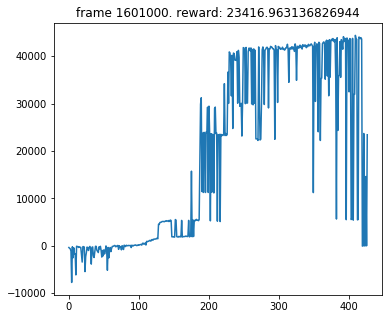

Finishline!!


In [5]:
value_network = ValueFunction(state_dim, hidden_units).to(device)
target_value_network = ValueFunction(state_dim, hidden_units).to(device)

q_network1 = QFunction(state_dim + action_dim, hidden_units).to(device)
q_network2 = QFunction(state_dim + action_dim, hidden_units).to(device)
policy_network = PolicyFunction(state_dim, action_dim, hidden_units).to(device)

for target_param, param in zip(target_value_network.parameters(), value_network.parameters()):
    target_param.data.copy_(param.data)

value_criterion = nn.MSELoss()
q_criterion1 = nn.MSELoss()
q_criterion2 = nn.MSELoss()

value_optimizer = optim.Adam(value_network.parameters(), lr=learning_rate)
q_optimizer1 = optim.Adam(q_network1.parameters(), lr=learning_rate)
q_optimizer2 = optim.Adam(q_network2.parameters(), lr=learning_rate)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=learning_rate)

replay_buffer = ReplayBuffer(replay_buffer_size)

while frame_idx < max_frames:
    env.reset()
    action = np.array([0, 0])
    state, reward, done, _ = env.step(action)
    episode_reward = 0

    for step in range(max_steps):
        if frame_idx >1000:
            action = policy_network.get_action(state)
            next_state, reward, done, _ = env.step(action)
        else:
            action = np.random.uniform(low = -1, high = 1.0, size=2)#env.action_space.sample
            next_state, reward, done, _ = env.step(action)

        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward
        frame_idx += 1

        if len(replay_buffer) > batchsize:
            train(batchsize)

        if frame_idx % 1000 == 0 and rewards:
            plot(frame_idx, rewards)

        if done:
            break
    rewards.append(episode_reward)
    if episode_reward > best_reward:
        torch.save(policy_network, output_dir)
        best_reward = episode_reward